In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ECG_function import *
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Data Importation

In [2]:
Xtrain,Ytrain,Xtest = DataImporting()
lable = Ytrain.TARGET.values

# I. Analyse Préliminaire


## I.1 DataSample 

On va définir la fonction DataSample(se trouve dans ECG_function.py) pour extraire les données par id(individu) et channel(chaîne).

In [3]:
#Test
DataSample(Xtrain,[1,2],3)

,ML3_0,ML3_1,ML3_2,ML3_3,ML3_4,ML3_5,ML3_6,ML3_7,ML3_8,ML3_9,...,ML3_740,ML3_741,ML3_742,ML3_743,ML3_744,ML3_745,ML3_746,ML3_747,ML3_748,ML3_749
1,0.000368,-0.002160,-0.004497,-0.006134,-0.005459,-0.003844,-0.003149,-0.004335,-0.006095,-0.006248,...,-0.004131,-0.003545,-0.002869,-0.002309,-0.001962,-0.001751,-0.001515,-0.001043,-0.000220,0.000895
2,0.016568,0.037517,0.035063,0.035143,0.036901,0.036132,0.036647,0.036375,0.035232,0.033861,...,-0.066095,-0.030852,0.029556,0.046187,0.044581,0.042301,0.050770,0.070837,0.084942,0.086189


## I.2 Interprétations Graphiques

#### TARGET = 0

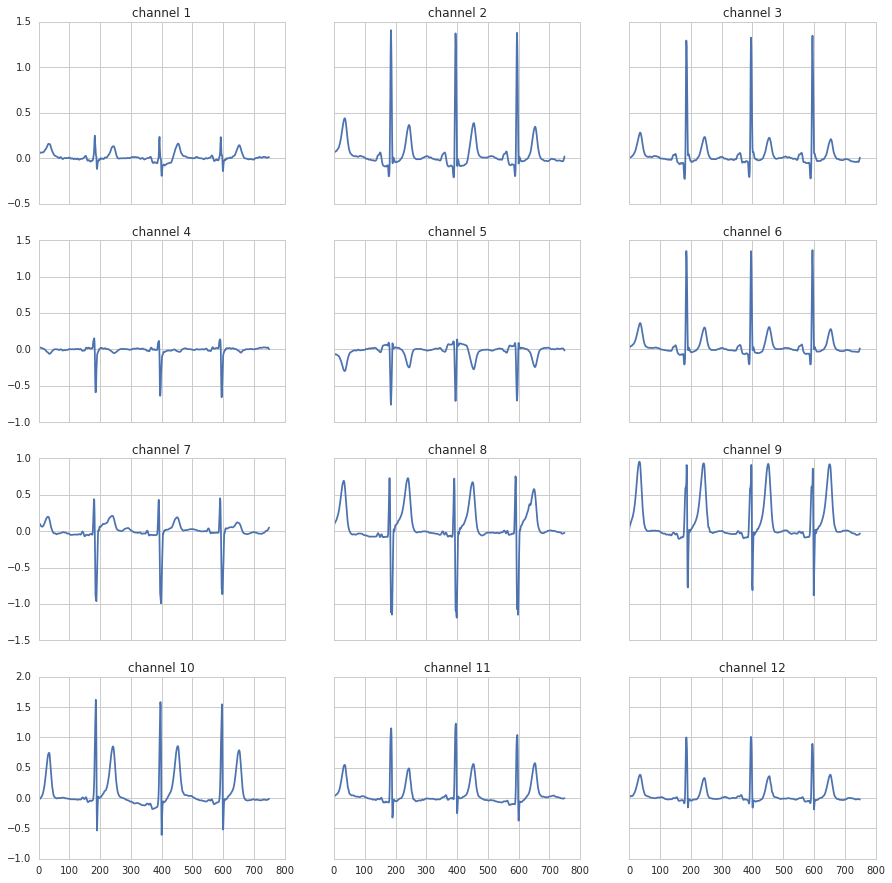

In [26]:
id = 4
fig, ((ax1, ax2, ax3), (ax4, ax5,ax6),(ax7, ax8, ax9), (ax10, ax11,ax12)) = plt.subplots(4, 3, sharex='col', sharey='row')
fig.set_size_inches(15, 15)

for (ax,i) in zip((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12),range(1,13,1)):
    ax.plot(DataSample(Xtrain,id,i).values)
    ax.set_title('channel '+str(i))
    

#### TARGET = 1

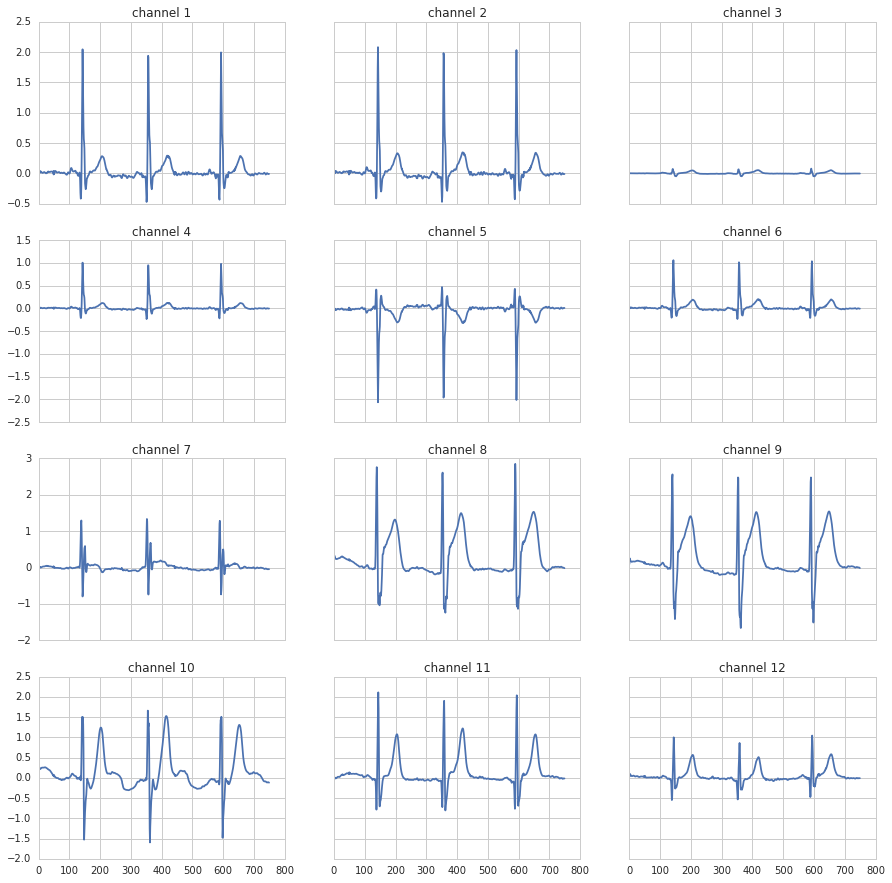

In [27]:
id = 0
fig, ((ax1, ax2, ax3), (ax4, ax5,ax6),(ax7, ax8, ax9), (ax10, ax11,ax12)) = plt.subplots(4, 3, sharex='col', sharey='row')
fig.set_size_inches(15, 15)

for (ax,i) in zip((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12),range(1,13,1)):
    ax.plot(DataSample(Xtrain,id,i).values)
    ax.set_title('channel '+str(i))
    

# II. Collection et Transformation des Données

In [21]:
AllFeatures = [[] for id in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures[id] += list(DataSample(Xtrain,id,k+1).values)

## II.1 Analyse en composantes principales (PCA)

In [23]:
from sklearn.decomposition import PCA
var_explained = []
for num_pca in range(100,1200,100):
    
    pca = PCA(n_components = num_pca)
    pca.fit(AllFeatures)
    var_explained += [np.sum(pca.explained_variance_ratio_)]


//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


([<matplotlib.axis.XTick at 0x14dc6ed10>,
 <a list of 10 Text xticklabel objects>)

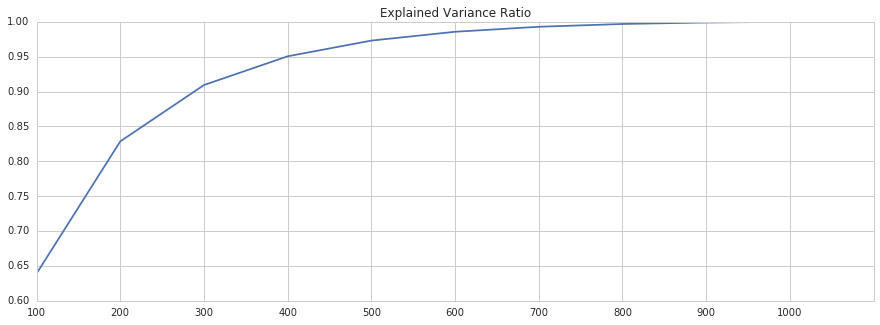

In [59]:
plt.figure(figsize = [15,5])
plt.plot(var_explained)
plt.title('Explained Variance Ratio')
plt.xticks(range(0,10),range(100,1200,100))

Selon le plot, on choisit num_pca = 1000

In [43]:
pca = PCA(n_components = 1000)
pca.fit(AllFeatures)
AllFeatures_pca = pca.transform(AllFeatures)

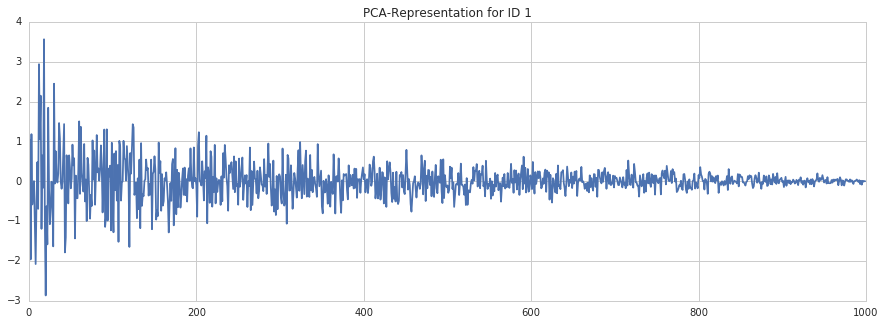

In [56]:
id = 1
plt.figure(figsize = [15,5])
plt.plot(AllFeatures_pca[id])
plt.title("PCA-Representation for ID 1")

## II.2 Transformation de Fourier (FFT)

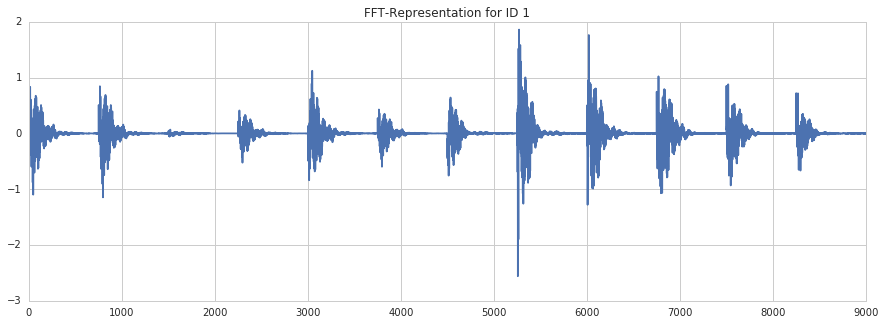

In [57]:
from scipy.fftpack import dct, idct

AllFeatures_fft =[[] for i in range(1000)]

for id in range(1000):
    for k in range(1,13):
        AllFeatures_fft[id] += list(dct(DataSample(Xtrain,id,k).values, norm='ortho'))
plt.figure(figsize=(15,5))
plt.plot(AllFeatures_fft[1])
plt.title("FFT-Representation for ID 1")

### Si on ne conserve que les [0:350]

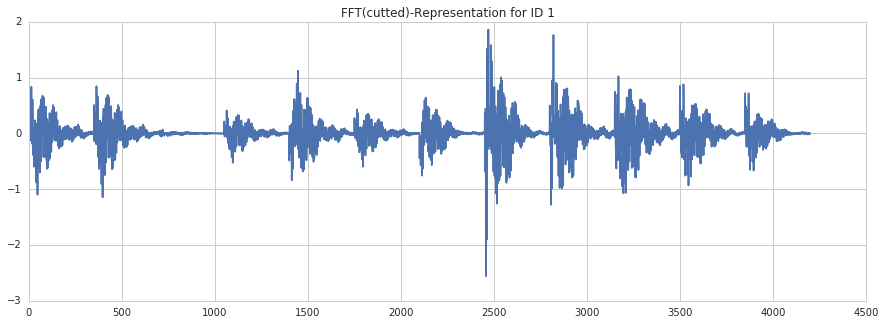

In [58]:
from scipy.fftpack import dct, idct

AllFeatures_fft_cutted =[[] for i in range(1000)]

for id in range(1000):
    for k in range(1,13):
        AllFeatures_fft_cutted[id] += list(dct(DataSample(Xtrain,id,k).values, norm='ortho'))[0:350]
plt.figure(figsize=(15,5))
plt.plot(AllFeatures_fft_cutted[1])
plt.title("FFT(cutted)-Representation for ID 1")

## II.3 Transformation de Ondelette (dwt)

In [68]:
import pywt

def WaveletExtraction(id,k): 
    a = list(pywt.dwt(DataSample(Xtrain,id,k+1).values, 'db2'))[0]
    a = list(pywt.dwt(a,'db2')[0])
    a = list(pywt.dwt(a,'db2')[0])
    a = list(pywt.dwt(a,'db2')[0])
    a = list(pywt.dwt(a,'db2')[0])
    a = list(pywt.dwt(a,'db2')[0])
    return a

AllFeatures_dwt =[[] for i in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures_dwt[id] += WaveletExtraction(id,k)

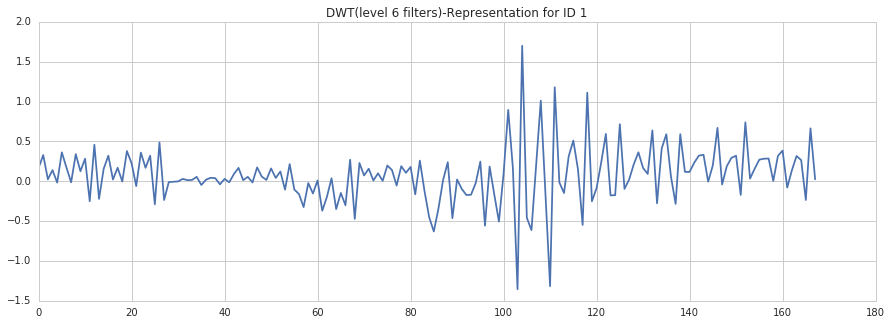

In [70]:
plt.figure(figsize=(15,5))
plt.plot(AllFeatures_dwt[1])
plt.title("DWT(level 6 filters)-Representation for ID 1")

## II.4 "PEAKS" Extraction

88


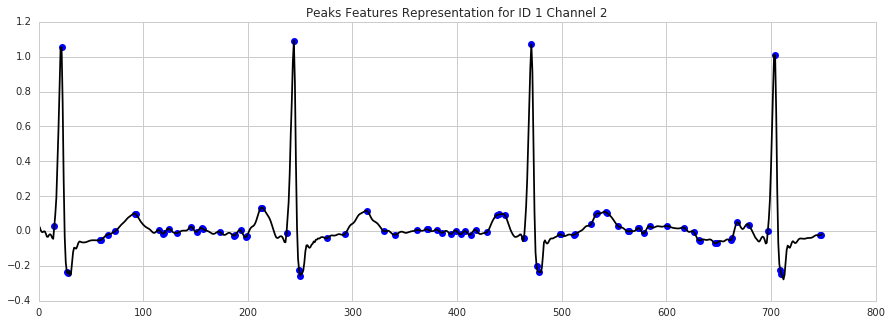

In [75]:
id = 1
channel = 2
test = DataSample(Xtrain,id,channel).values 
from scipy import signal
sig_cwt = list(signal.cwt(test, signal.ricker,np.arange(1,15)))[5]
points_positive = signal.find_peaks_cwt(test,np.arange(2,4))
points_negative = signal.find_peaks_cwt(-test,np.arange(2,4))
points = points_positive+points_negative
def f(x):
    return test[x]


plt.figure(figsize = [15,5])
plt.plot(points, f(points),'bo',range(750),f(range(750)),'k')
plt.title("Peaks Features Representation for ID 1 Channel 2")
print len(points)

#### On peut aussi ajouter une seuil pour enlever tous les "petit peaks". 


In [71]:
def PeakFeature(wave):
    points_positive = signal.find_peaks_cwt(wave,np.arange(2,4))
    points_negative = signal.find_peaks_cwt(-wave,np.arange(2,4))
    points = points_positive+points_negative
    #threshold = 0.25*np.std(sorted([wave[i] for i in points]))
    peak_feature = [0 for i in range(len(wave))]
#     for i in points:
#         #if np.abs(wave[i]) > threshold:
#         peak_feature[i] = wave[i]
    for i in points:
        peak_feature[i] = wave[i]
    return peak_feature

In [ ]:
AllFeatures_peaks = [[[]for k in range(12)]for id in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures_peaks[id][k] = PeakFeature(DataSample(Xtrain,id,k+1).values)

In [ ]:
# import cPickle
# myBigList = AllFeatures_peaks
# savefilePath = 'sample data/AllFeatures_peaks.csv'
# with open(savefilePath, 'w') as savefile:
#   cPickle.dump(AllFeatures_peaks, savefile)

In [72]:
import cPickle
savefilePath = 'sample data/AllFeatures_peaks.csv'
with open(savefilePath) as savefile:
  AllFeatures_peaks = cPickle.load(savefile)

# III. Sélection de Variables

## III.1 SelectKBest (ANOVA ou F-test)

On va couper l'ensemble en deux parties, une pour l'apprentissage et l'autre pour le test.

AllFeatures_collected est les variables collecté.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
N_sep = len(lable)*2/3

AllFeatures_collected = 
num_features = 300

Select = SelectKBest(f_classif, k=num_features)
Select.fit(AllFeatures_collected[0:N_sep], lable[0:N_sep])
SelectedFeatures = Select.transform(AllFeatures_collected[N_sep:])

np.shape(SelectedFeatures)
Select.get_support

## III.2 Sélection à la main. (max abs)


### III.1 Sélection de PCA

#### III.1.1 Découpage Directe

In [85]:
SelectedFeatures = [[] for i in range(1000)]
num_compca = 100

for i in range(1000):

    SelectedFeatures[i] = AllFeatures_pca[i][0:num_compca] 
        

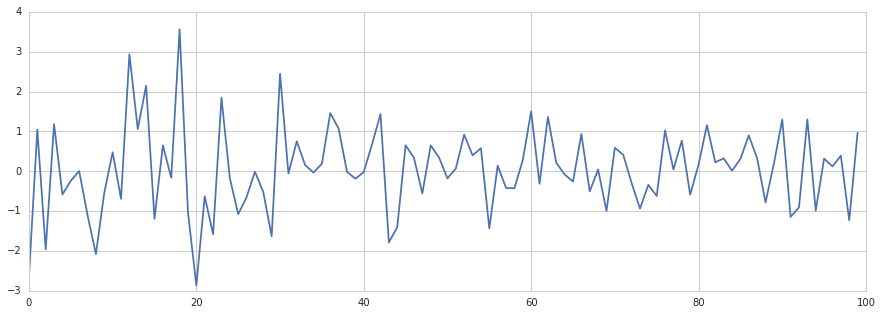

In [86]:
plt.figure(figsize = [15,5])
plt.plot(SelectedFeatures[1])

#### III.1.2 Max-abs

In [90]:
AllFeatures_pca_sorted = [[]for i in range(1000)]
for id in range(1000):
        AllFeatures_pca_sorted[id] = list(sorted(AllFeatures_pca[id]))

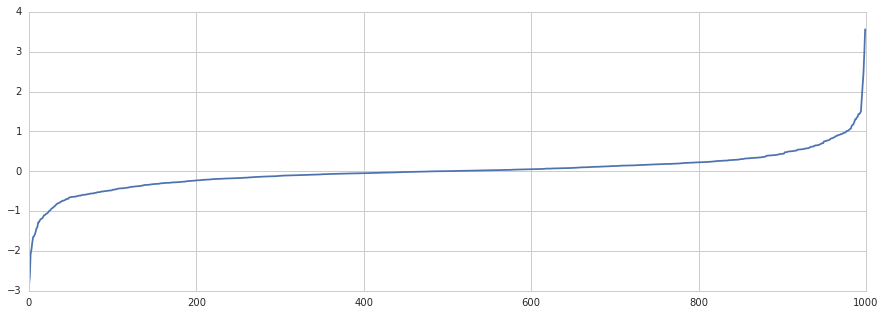

In [84]:
plt.figure(figsize = [15,5])
plt.plot(AllFeatures_pca_sorted[1])

In [91]:
SelectedFeatures = [[] for i in range(1000)]
for i in range(1000):

    SelectedFeatures[i] += [AllFeatures_pca_sorted[i][j] for j in range(1,25,1)]
    SelectedFeatures[i] += [AllFeatures_pca_sorted[i][j] for j in range(975,1000,1)]

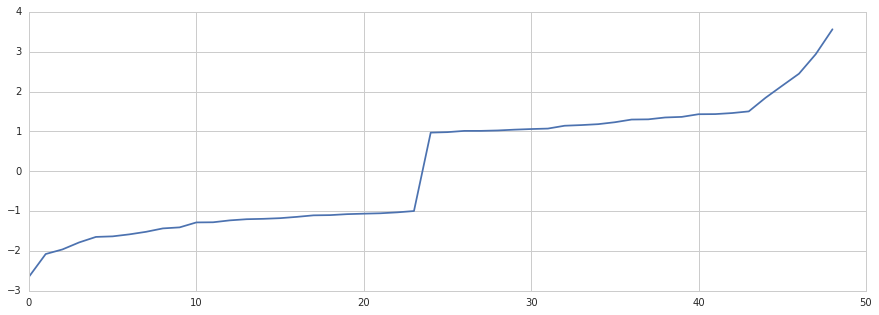

In [92]:
plt.figure(figsize = [15,5])
plt.plot(SelectedFeatures[1])

### III.2 Sélection de Peaks

In [77]:
AllFeatures_peaks_sorted = [[[]for k in range(12)]for i in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures_peaks_sorted[id][k] = list(sorted(AllFeatures_peaks[id][k]))

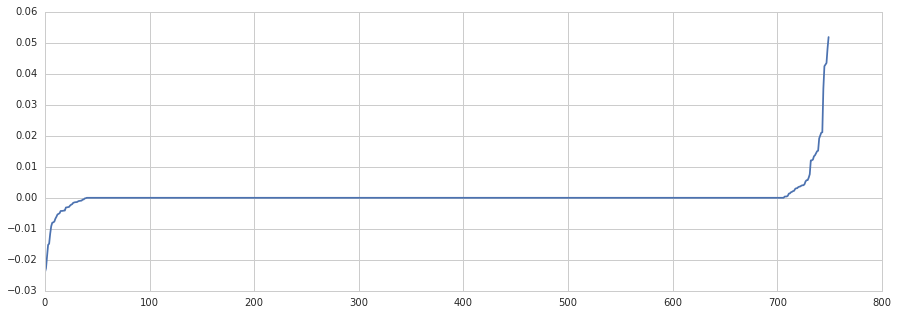

In [79]:
plt.figure(figsize = [15,5])
plt.plot(AllFeatures_peaks_sorted[1][2])

On peut extraire les peaks qui sont plus "grandes", c-à-d avec valeur absolue plus grands.

On essaye de retirer les information des peaks positives(resp. négatives) plus grandes et 2ème plus grandes.

c'est pourquoi on va prendre range(2,15,1) et range(735,748,1).



In [81]:
SelectedFeatures = [[] for i in range(1000)]
for i in range(1000):
    for k in range(12):
        SelectedFeatures[i] += [AllFeatures_peaks_sorted[i][k][j] for j in range(2,15,1)]
        SelectedFeatures[i] += [AllFeatures_peaks_sorted[i][k][j] for j in range(735,748,1)]

In [ ]:
# IV. 